In [13]:
import tensorflow as tf
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import helper_functions as hp
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch import nn
from torch.optim import Adam
from torchvision.transforms import  Compose, ToTensor, Resize, RandomHorizontalFlip, RandomRotation, ColorJitter, RandomResizedCrop, Lambda
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
import torchmetrics
from lightning.pytorch.loggers import WandbLogger
import wandb
import random
from datetime import datetime
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [14]:
num_workers = 0

device = torch.device("cpu")

### MacOS

Set start method to fork and device to metal

In [15]:
import torch.multiprocessing as mp
mp.set_start_method("fork", force=True)  # Ensure fork is used on macOS

device = torch.device("cpu")

if torch.mps.is_available():
    #torch.mps.set_buffer_capacity(1)
    #torch.mps.set_reuse_buffers(True)
    #torch.mps.initialize()
    device = torch.device("mps")
    num_workers = 11

## Linux

In [6]:
print("CUDA verfügbar:", torch.cuda.is_available())
print("CUDA-Version:", torch.version.cuda)
print("GPU-Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Keine GPU gefunden")

if torch.cuda.is_available():
    device = torch.device("cuda")
    num_workers = 2


CUDA verfügbar: False
CUDA-Version: None
GPU-Name: Keine GPU gefunden


## Load dataset

In [16]:
# Dataset Path
DATASET_PATHS = ["../Dataset/local_dataset_all/train"]
DATASET_PATHS_TEST = ["../Dataset/local_dataset_all/test"]
DATASET_PATHS_VALID = ["../Dataset/local_dataset_all/val"] # Not used yet
DATASET_PATH_SPLIT = "../Dataset/MIT_local_data" # This dataset is split between train, val and test
PRICES_FILE_PATH = "../Dataset/prices.txt"
IMAGE_SIZE = (200, 200)
BATCH_SIZE = 1
SEED = 42

In [17]:
num_classes = hp.get_num_classes(PRICES_FILE_PATH)
print(num_classes)

61


In [18]:
import torch
import random
import matplotlib.pyplot as plt
import wandb

def show_predictions_with_prices_and_manual_metrics(model, test_dataset, prices, num_samples=20, threshold=0.5):
    model.eval()  # Setze das Modell in den Evaluierungsmodus
    samples = random.sample(range(len(test_dataset)), num_samples)  # Wähle zufällig Samples aus

    all_true_prices = []
    all_predicted_prices = []

    for idx in samples:
        image, labels = test_dataset[idx]  # Lade das Bild und die Multi-Label Labels
        image_tensor = image.unsqueeze(0).to(model.device)  # Füge Batch-Dimension hinzu und verschiebe auf GPU/CPU

        # Vorhersage erzeugen
        with torch.no_grad():
            prediction = model(image_tensor).cpu().squeeze()  # Entferne die Batch-Dimension und bringe auf CPU

        # Erstelle ein Dictionary für Vorhersagen über dem Schwellenwert
        predicted_labels = {i: pred.item() for i, pred in enumerate(prediction) if pred.item() > threshold}
        
        # Erstelle ein Dictionary für die tatsächlichen Labels (hier annehmen, dass 1 für das Vorhandensein einer Klasse steht)
        true_labels = {i: label.item() for i, label in enumerate(labels) if label.item() > 0.5}

        # Berechne die Gesamtpreise basierend auf den Labels
        true_price = sum(prices[label+1][1] for label in true_labels.keys() if label+1 in prices)
        predicted_price = sum(prices[label+1][1] for label in predicted_labels.keys() if label+1 in prices)

        # Speichere die Preise für die Metrikberechnung
        all_true_prices.append(true_price)
        all_predicted_prices.append(predicted_price)

        # Formatierte Strings für die Anzeige
        predicted_labels_str = "\n".join([f"{prices[key+1][0]}: {value:.2f} €" for key, value in predicted_labels.items() if key+1 in prices])
        true_labels_str = "\n".join([f"{prices[key+1][0]}: {value:.2f} €" for key, value in true_labels.items() if key+1 in prices])

        # Bild anzeigen
        plt.figure(figsize=(6, 6))
        plt.imshow(image.permute(1, 2, 0))  # Konvertiere das Tensor-Bild in HWC-Format
        plt.title(f"True Labels:\n{true_labels_str}\nTrue Price: {true_price:.2f} €\n\n"
                  f"Predictions:\n{predicted_labels_str}\nPredicted Price: {predicted_price:.2f} €")
        plt.axis("off")
        plt.show()

        try:
            wandb.log({"predictions": wandb.Image(plt)})
        except Exception as e:
            print(f"Couldn't log predictions to wandb: {e}")

    # Manuelle Berechnung von MSE und MAE
    mse = sum((true - pred) ** 2 for true, pred in zip(all_true_prices, all_predicted_prices)) / len(all_true_prices)
    mae = sum(abs(true - pred) for true, pred in zip(all_true_prices, all_predicted_prices)) / len(all_true_prices)

    # MSE und MAE ausgeben
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")

    return mse, mae




def configure_wandb(additional_name="", tags=[]):
    # Sort the dataset names aplhabetically
    dataset_names = "-".join(sorted([os.path.basename(path) for path in DATASET_PATHS]))
    group = "Regression-"+dataset_names
    name = dataset_names+additional_name+"_"+datetime.now().strftime("%d%b-%H:%M:%S")

    wandb_logger = WandbLogger(project="TinyML-CartDetection", group=group, name=name, tags=tags)   
    wandb_logger.experiment.config.update({"batch_size": BATCH_SIZE, "image_size": IMAGE_SIZE, "seed": SEED}) # Log additional hyperparameters

    return wandb_logger

In [19]:
class ImagePriceDataset(Dataset):
    def __init__(self, dataset_paths, transform=None):
        self.files = []
        for dataset_path in dataset_paths:
            if not os.path.exists(dataset_path):
                raise ValueError(f"Path {dataset_path} doesn't exist.")
            for f in os.listdir(dataset_path):
                if f.endswith(".jpg"):
                    self.files.append((f, dataset_path))
        
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name, dataset_path = self.files[idx]
        image, label = hp.load_image_labels_classify(file_name, dataset_path, IMAGE_SIZE, num_classes)

        # Wenn das Bild im float32 Format vorliegt, skaliere es und wandle es in uint8 um
        if image.dtype == np.float32:
            image = (image * 255).astype(np.uint8)  # Skalieren auf [0, 255] und in uint8 umwandeln

        # Konvertiere das numpy-Array in ein PIL-Image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

In [20]:
class TrainModel(pl.LightningModule):
    def __init__(self, model, prices, learning_rate=1e-3, optimizer=None):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.model = model
        self.prices = prices
        self.criterion = nn.MSELoss()
        self.mae = torchmetrics.MeanAbsoluteError()
        self.mse = torchmetrics.MeanSquaredError()
        self.optimizer = optimizer
        self.threshold = 0.5
        #self.save_hyperparameters() #ignore=['model']

    def forward(self, x):
        return self.model(x)

    def calculate_total_price(self, predictions, labels):
        """
        Berechnet den Gesamtpreis basierend auf den Vorhersagen und tatsächlichen Labels
        """
        # Vorhersagen und tatsächliche Labels basierend auf Threshold filtern
        predicted_labels = [i for i, pred in enumerate(predictions) if pred > self.threshold]
        true_labels = [i for i, label in enumerate(labels) if label > 0.5]
        print(predicted_labels, true_labels)
        # Berechnung der Gesamtpreise
        predicted_price = sum(self.prices[label][1] for label in predicted_labels if label in self.prices)
        true_price = sum(self.prices[label][1] for label in true_labels if label in self.prices)

        return predicted_price, true_price

    def step(self, batch, stage):
        x, y = batch
        y_pred = self(x)  # Vorhersagen
        # Hauptverlust berechnen (MSE auf allen Labels)
        loss = self.criterion(y_pred, y)
 
        # MAE und MSE der Hauptlabels
        mae = self.mae(y_pred, y)
        mse = self.mse(y_pred, y)

        # Berechnung der Gesamtpreise
        batch_predicted_prices = []
        batch_true_prices = []
        for i in range(len(y)):
            predicted_price, true_price = self.calculate_total_price(y_pred[i], y[i])
            batch_predicted_prices.append(predicted_price)
            batch_true_prices.append(true_price)

        # Manuelle Berechnung von MAE und MSE für Gesamtpreise
        total_mae = sum(abs(tp - pp) for tp, pp in zip(batch_true_prices, batch_predicted_prices)) / len(batch_true_prices)
        total_mse = sum((tp - pp) ** 2 for tp, pp in zip(batch_true_prices, batch_predicted_prices)) / len(batch_true_prices)

        # Logs für Progress-Bar und Training/Validierung/Test
        self.log(f"{stage}_loss", loss, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_mae", mae, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_mse", mse, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_total_mae", total_mae, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_total_mse", total_mse, prog_bar=True, on_epoch=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.step(batch, stage="train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, stage="val")

    def test_step(self, batch, batch_idx):
        return self.step(batch, stage="test")

    def configure_optimizers(self):
        if self.optimizer is None:
            self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Scheduler erstellen
        scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.965)
        return [self.optimizer], [scheduler]


In [21]:
class TFLiteWrapper(torch.nn.Module):
    def __init__(self, tflite_model_path):
        super().__init__()
        self.interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
        self.interpreter.allocate_tensors()
        
        # Get model details
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        
        print("Input details:", self.input_details)
        print("Output details:", self.output_details)
        
        # Get quantization parameters
        self.input_scale = self.input_details[0]['quantization_parameters']['scales'][0]
        self.input_zero_point = self.input_details[0]['quantization_parameters']['zero_points'][0]
        print(self.input_scale, self.input_zero_point)

    def forward(self, input_image):
        input_image = input_image.permute(0, 2, 3, 1)  # Convert from (N, C, H, W) to (N, H, W, C)
        # Quantize input: (float32 -> int8)
        input_image = torch.round(input_image / self.input_scale + self.input_zero_point)
        
        # Clip values to int8 range [-128, 127]
        input_image = torch.clamp(input_image, -128, 127).to(torch.int8)

        # Convert the input image to NumPy before passing to TFLite
        input_image = input_image.numpy()  # Convert to NumPy

        # Set input tensor for inference
        self.interpreter.set_tensor(self.input_details[0]['index'], input_image)
        self.interpreter.invoke()

        # Get the output tensor from the interpreter
        output_data = self.interpreter.get_tensor(self.output_details[0]['index'])

        # Dequantize output: Convert int8 back to float32
        output_scale = self.output_details[0]['quantization_parameters']['scales'][0]
        output_zero_point = self.output_details[0]['quantization_parameters']['zero_points'][0]
        
        # Dequantization process
        output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale
        output_data = torch.tensor(output_data)
        return output_data

transform_test = Compose([
    ToTensor(),  # This will convert to NCHW format
])

In [11]:
prices = hp.get_combined_dict(PRICES_FILE_PATH)
print(prices)

tflite_model_path = "quantization/big-model_quantized.tflite"
#tflite_model_path = "quantization/big-tf_model/big-model_float32.tflite"
test_dataset = ImagePriceDataset(DATASET_PATHS_TEST, transform=transform_test)
model = TrainModel(TFLiteWrapper(tflite_model_path), prices=prices)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=num_workers)

{1: ['apple', 0.6], 2: ['lemon', 0.49], 3: ['avocado', 1.29], 4: ['banana', 0.46], 5: ['tomato sauce', 1.19], 6: ['schweppes', 2.19], 7: ['vitamine water', 1.19], 8: ['salt', 1.29], 9: ['pasta', 2.69], 10: ['brush', 0.79], 11: ['red fruit jelly', 2.29], 12: ['cup noodles ', 2.19], 13: ['coffee', 7.99], 14: ['lemon cake baking mix ', 3.49], 15: ['lettuce', 1.11], 16: ['bread', 1.89], 17: ['curry sauce', 2.29], 18: ['tomato ketchup', 2.29], 19: ['lemon juice', 1.59], 20: ['spaghetti', 1.29], 21: ['kinder riegel', 2.99], 22: ['beetroot', 1.79], 23: ['pickles', 3.49], 24: ['detergent', 3.79], 25: ['maggi wok', 1.05], 26: ['tea', 2.35], 27: ['nic nacs', 1.99], 28: ['pedigree dog food', 2.29], 29: ['pringles', 2.49], 30: ['balsamico', 2.69], 31: ['cat food bowl', 0.65], 32: ['potatoes', 1.99], 33: ['red tea', 2.49], 34: ['hella water', 0.79], 35: ['gouda', 2.19], 36: ['oat milk', 0.99], 37: ['salami', 1.79], 38: ['chickpeas', 0.59], 39: ['cereals', 2.49], 40: ['packaged cereal bars', 1.99], 

In [22]:
model = hp.TrainModel.load_from_checkpoint("checkpoints/classifier/train_Efficientnet-classifier_26Jan-06:59:36.ckpt")
model = model.cpu()

/Users/mats/miniconda3/envs/ML/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [28]:
# Load an image from the test dataset

#image, label = test_dataset[0]  # Change the index to load a different image

# Load an image from a file
image_path = os.path.join(DATASET_PATHS_TEST[0], "../../../temp_images/captured_image_0.jpg")  # Replace "example.jpg" with your image file name
image = Image.open(image_path)
image = image.resize((200,200))

image.show()

image = transform_test(image)

# Add batch dimension and move to the appropriate device
image_tensor = image.unsqueeze(0)


# Put the image through the model
model.eval()
with torch.no_grad():
    prediction = model(image_tensor).cpu().squeeze()

predicted_labels = [i for i, pred in enumerate(prediction) if pred > 0.5]
# Print the prediction
print("Prediction:", predicted_labels)


Prediction: [0]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/Users/mats/miniconda3/envs/ML/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Testing: |          | 0/? [00:00<?, ?it/s]

[0, 3] [0, 1, 3]
[0, 1] [0, 1]
[1, 4] [1, 4]
[1, 4] [1, 4]
[1, 4] [1, 4]
[0, 2, 3, 47] [0, 2, 3, 47]
[0, 1, 3, 4] [0, 1, 3, 4]
[0, 3] [0, 1, 3]
[0, 1, 2, 3] [0, 1, 2, 3]
[1, 2, 3, 25, 47] [1, 2, 3, 4, 25, 47]
[12] [12]
[1, 2, 3, 4, 25, 47] [1, 2, 3, 4, 25, 47]
[2] [2]
[12] [12]
[47] [47]
[2, 3] [2, 3]
[2, 3] [2, 3]
[0, 4] [0, 4]
[0, 4] [0, 4]
[0, 2, 3, 47] [0, 2, 3, 47]
[0, 4] [0, 4]
[0, 2, 3, 47] [0, 2, 3, 47]
[0, 1, 2, 8, 12] [0, 1, 2, 8, 12, 25]
[0, 1, 2, 3] [0, 1, 2, 3]
[0, 1, 2] [0, 1, 2]
[0, 3] [0, 3, 4]
[0, 3, 4] [0, 3, 4]
[0, 1, 2] [0, 1, 2]
[0, 1, 2, 3] [0, 1, 2, 3]
[0, 1, 2, 8, 12] [0, 1, 2, 8, 12, 25]
[0, 2, 3, 47] [0, 2, 3, 47]
[0, 4] [0, 4]
[0, 2, 3, 47] [0, 2, 3, 47]
[0, 4] [0, 4]
[0, 4] [0, 4]
[2, 3] [2, 3]
[2, 3] [2, 3]
[47] [47]
[12] [12]
[2] [2]
[1, 2, 3, 4, 25, 47] [1, 2, 3, 4, 25, 47]
[12] [12]
[1, 2, 3, 4, 25, 47] [1, 2, 3, 4, 25, 47]
[0, 1, 2, 3] [0, 1, 2, 3]
[0, 3] [0, 1, 3]
[0, 1, 3, 4] [0, 1, 3, 4]
[0, 2, 3, 47] [0, 2, 3, 47]
[1, 4] [1, 4]
[1, 4] [1, 4]
[1, 4] 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.009317361749708652    │
│         test_mae          │   0.028201807290315628    │
│         test_mse          │   0.009317361749708652    │
│      test_total_mae       │    0.16933828592300415    │
│      test_total_mse       │    0.17995433509349823    │
└───────────────────────────┴───────────────────────────┘

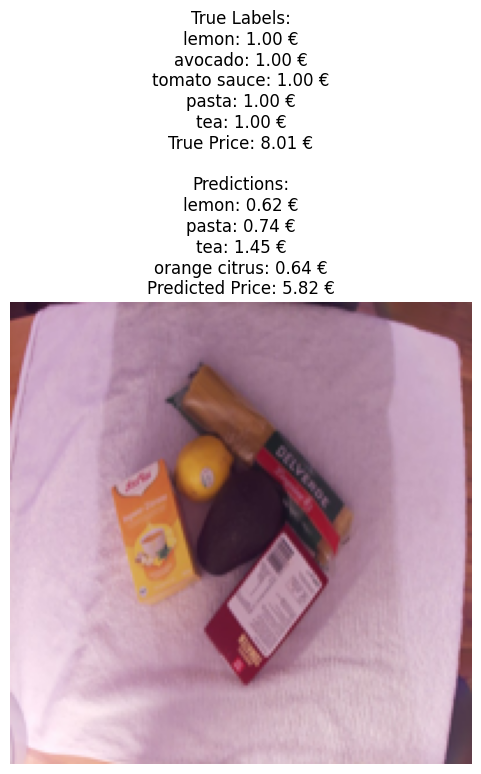

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

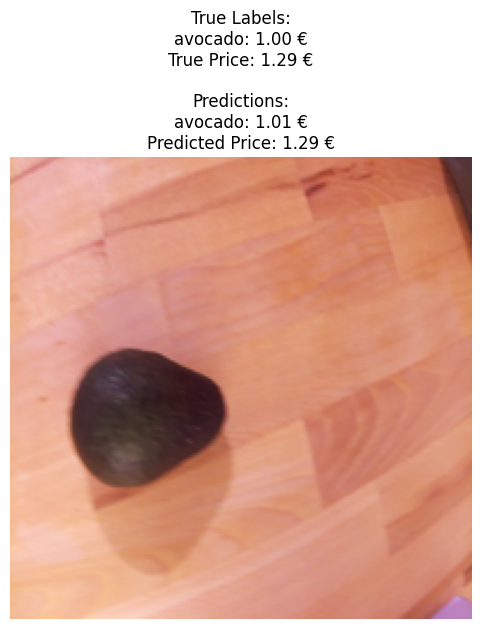

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

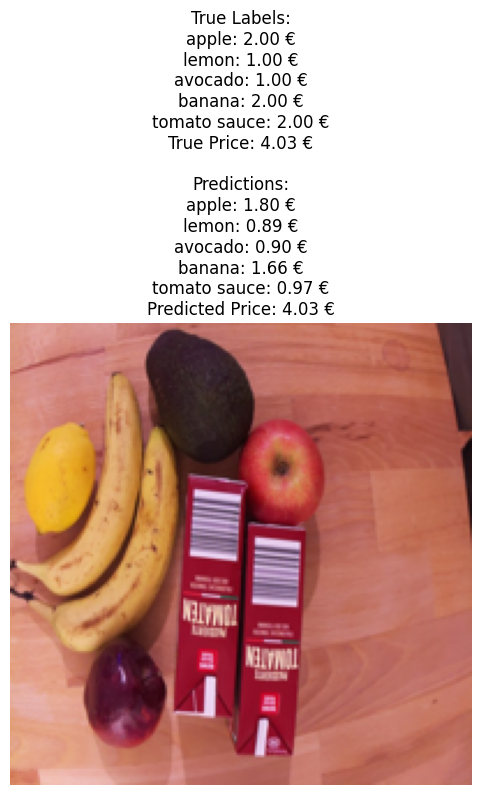

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

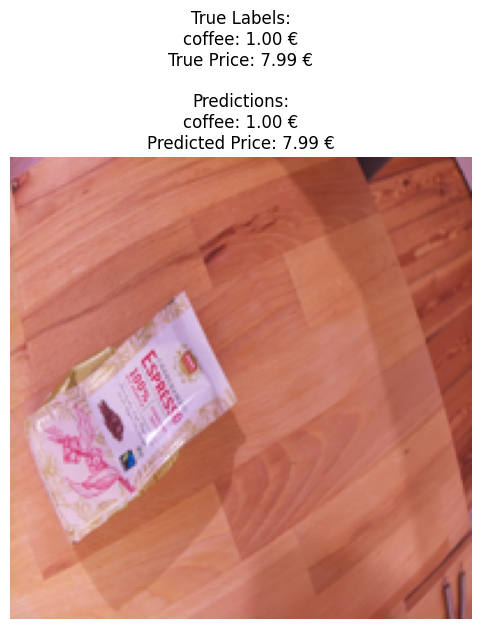

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

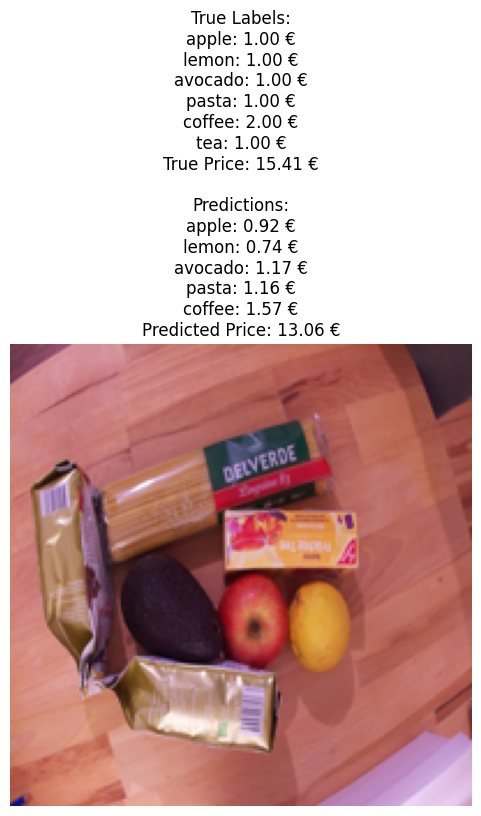

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

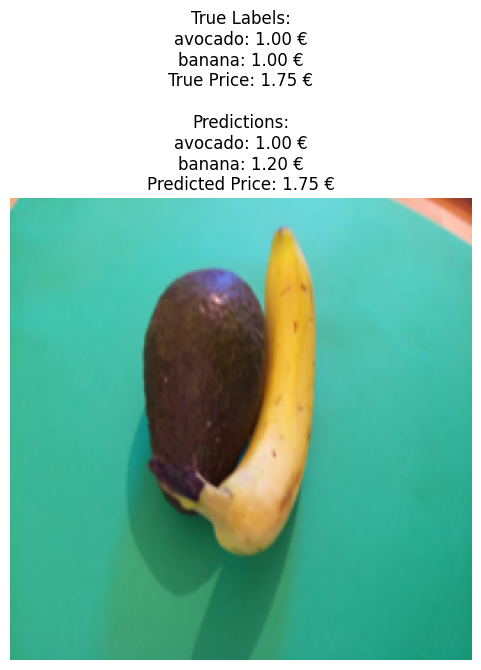

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

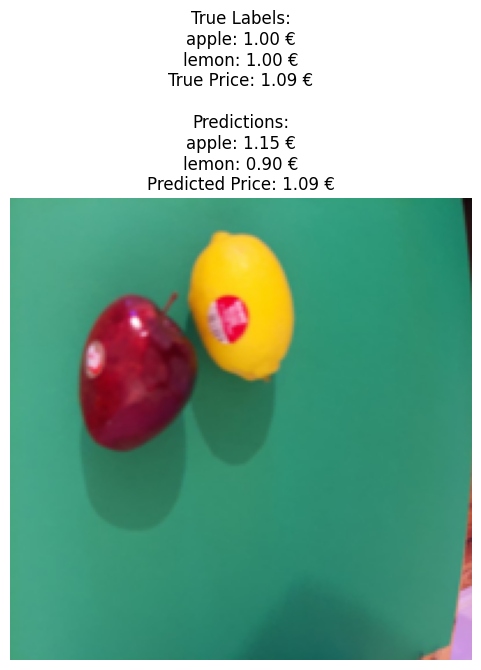

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

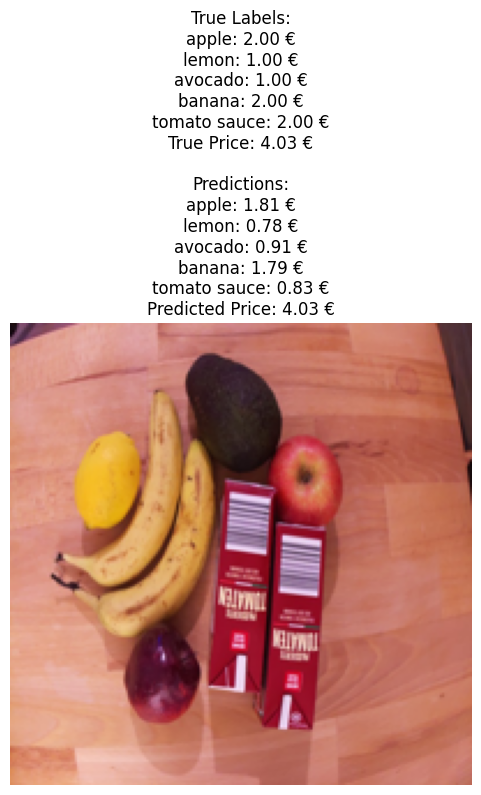

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

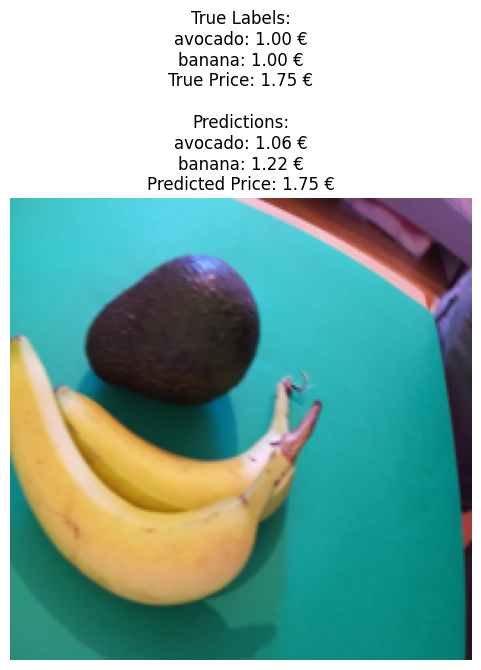

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

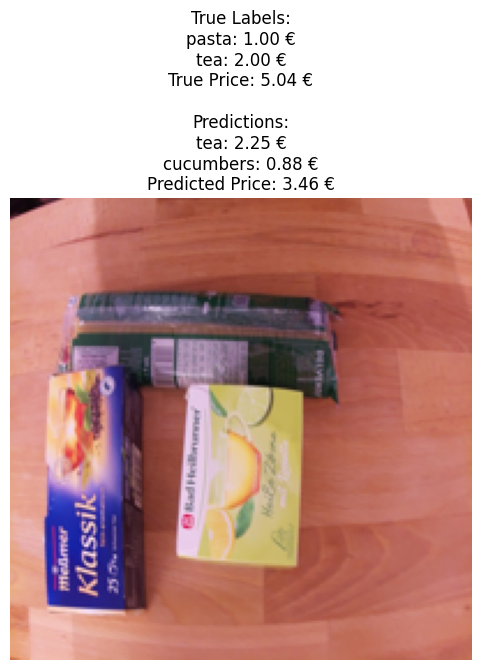

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

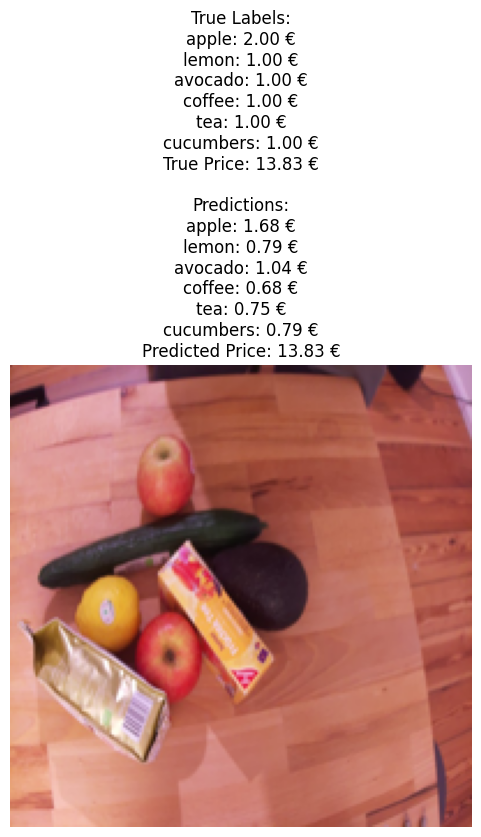

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

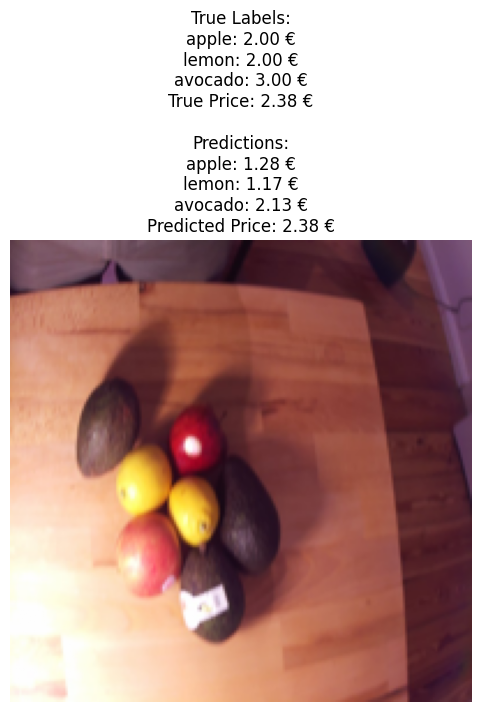

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

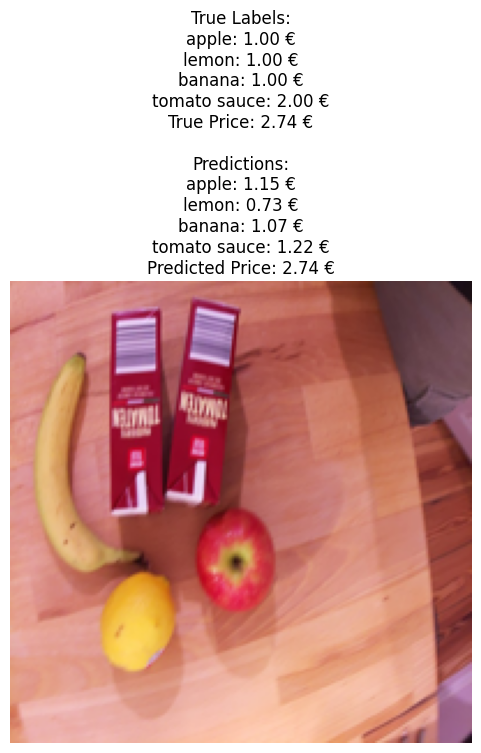

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

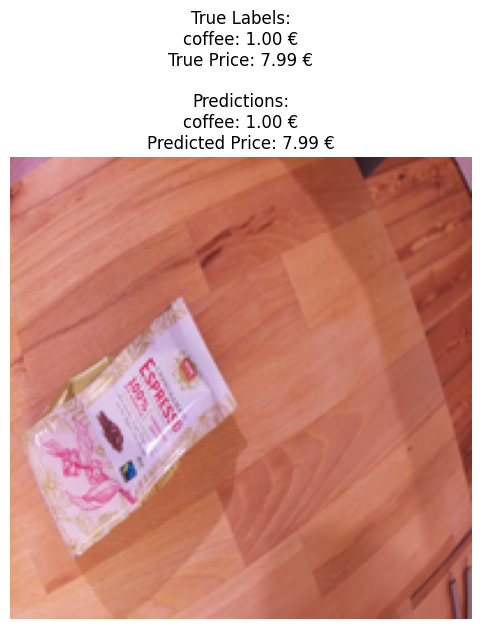

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

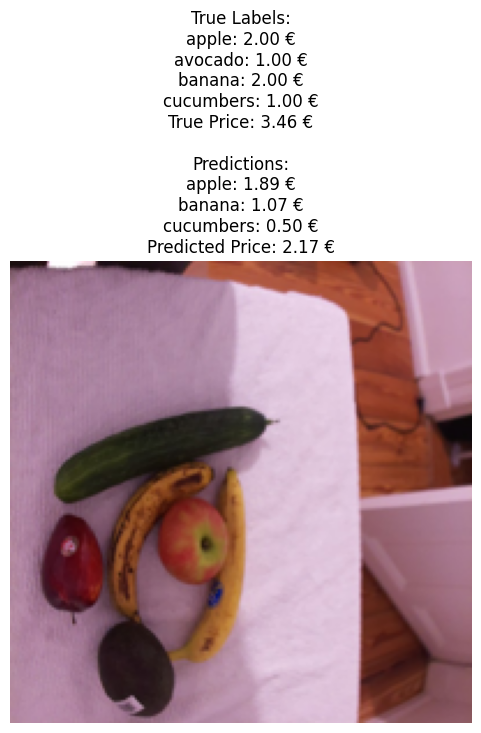

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

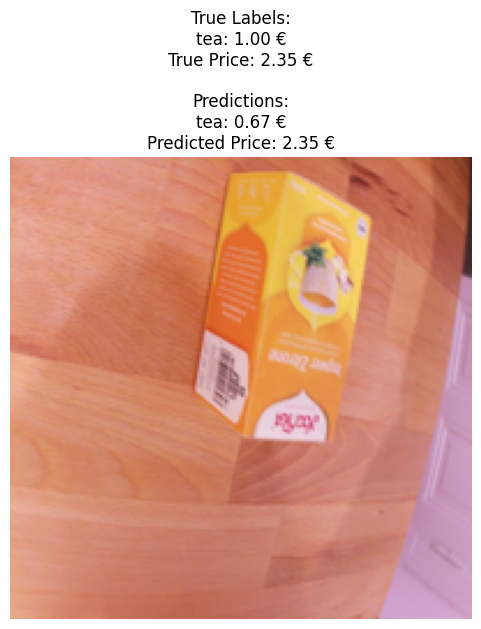

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

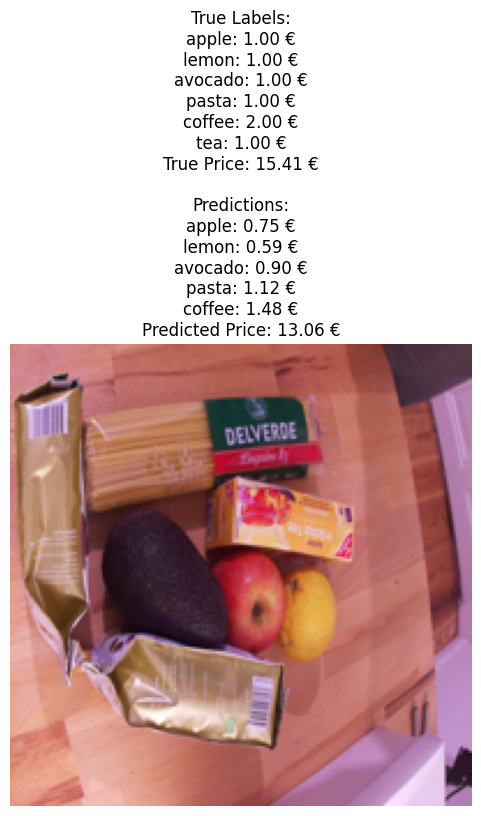

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

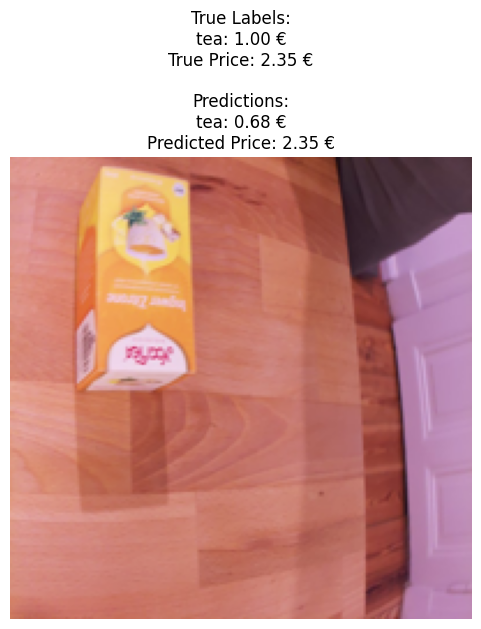

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

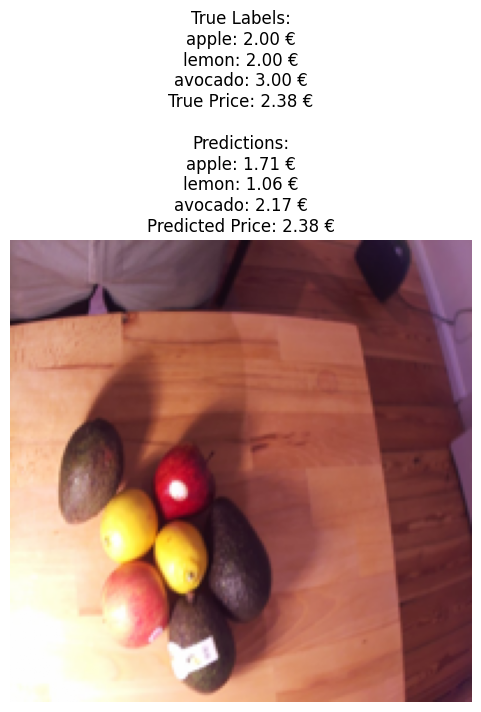

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()


<Figure size 640x480 with 0 Axes>

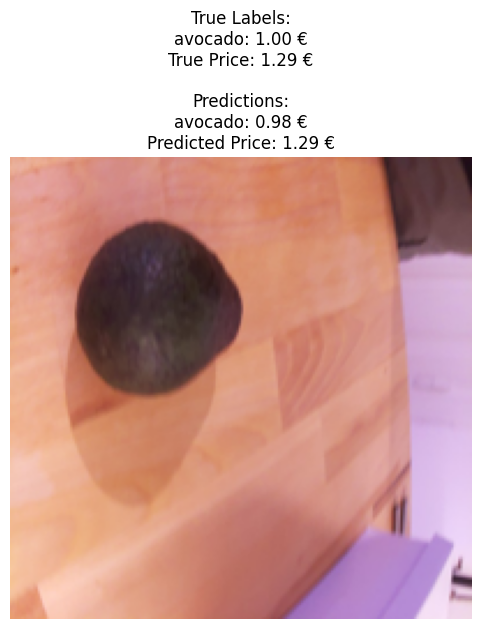

Couldn't log predictions to wandb: You must call wandb.init() before wandb.log()
Mean Squared Error (MSE): 1.00
Mean Absolute Error (MAE): 0.49


(1.00008, 0.488)

<Figure size 640x480 with 0 Axes>

In [12]:
trainer = pl.Trainer(accelerator='cpu', devices=1)
trainer.test(model, test_loader)
show_predictions_with_prices_and_manual_metrics(model, test_dataset, prices) 
